In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv


# <center><font color = "green">PUBG Game Prediction</font></centre>

# Importing Libraries

In [45]:
# handling warnings
import warnings
warnings.filterwarnings("ignore")

# standard libraries
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Reading the Data

In [46]:
df = pd.read_csv('/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv')

In [47]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


# Data Wrangling

### Check for the rows with missing win prediction value

In [48]:
# check row with NULL win prediction value
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [49]:
# remove the data row
df.drop(2744604, inplace = True)
# df = df.drop(2744604)

### Understanding Players distribution in a game

In [50]:
# prepare new parameter to know how many players are in a game
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

In [51]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


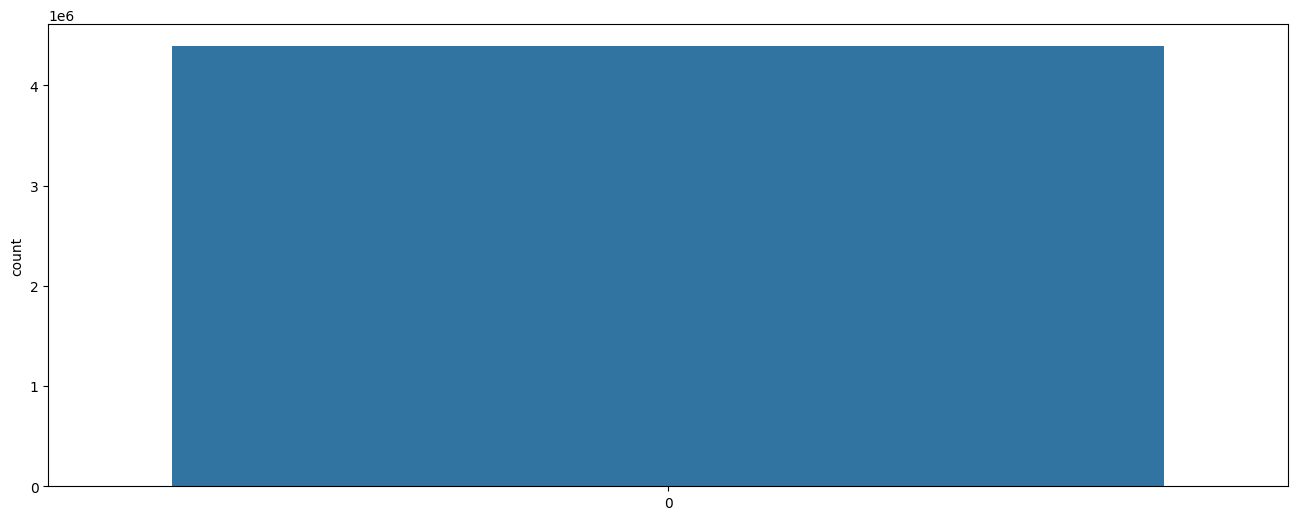

In [52]:
sns.countplot(df[df['playersJoined']>=75]['playersJoined'])
plt.show()

### Analysing the data

#### Kills Without Moving?

In [53]:
# prepare a data parameter to gather the information of the total distance travelled
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

# prepare a data parameter to check for anamoly detection that
# the person has not moved but still managed to do the kills
df['killswithoutMoving'] = ((df['kills']>0) & (df['totalDistance'] ==0))

In [54]:
df[df['killswithoutMoving'] == True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [55]:
df[df['killswithoutMoving'] == True].shape

(1535, 32)

In [56]:
# drop the table
df.drop(df[df['killswithoutMoving'] == True].index , inplace = True)

### Extra-ordinary Road Kills?????

In [57]:
df[df['roadKills'] > 5].shape

(46, 32)

In [58]:
df.drop(df[df['roadKills'] > 5].index, inplace = True)

### So many KILLS - how ????

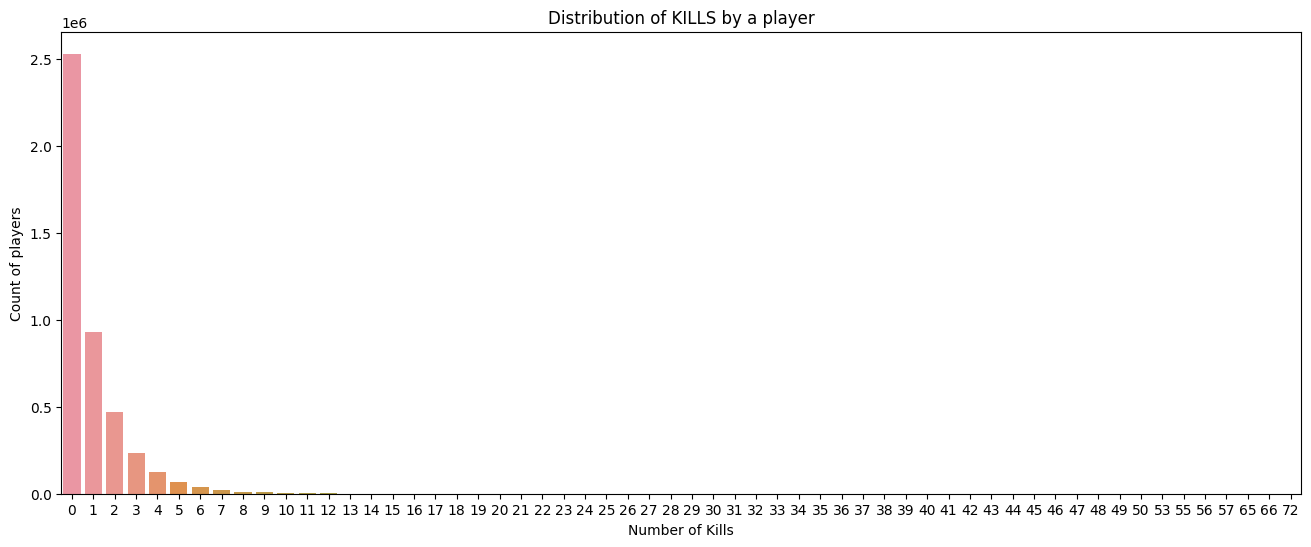

In [59]:
sns.countplot(data = df, x = df['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

In [60]:
sns.countplot(df[df['kills']>=15]['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

KeyError: 0

In [61]:
# data dimension
df[df['kills'] > 20].shape

(417, 32)

In [62]:
# drop the instances
df.drop(df[df['kills'] > 20].index, inplace = True)

### Head Shot

In [64]:
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

In [ ]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [ ]:
df[(df['headshot_rate'] ==1) & (df['kills']>5)].shape

In [ ]:
df.drop(df[(df['headshot_rate'] == 1)& (df['kills'] > 6)].index, inplace = True)

### Longest Shot

In [ ]:
sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

In [ ]:
df[df['longestKill']>=500].shape

In [ ]:
df.drop(df[df['longestKill']>=500].index, inplace = True)

## Weapon Change

In [ ]:
sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [ ]:
df[df['weaponsAcquired']>=15].shape

In [ ]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

## EDA

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
# correlation of parameter with Win Prediction
plt.figure(figsize=[30,30])
sns.heatmap(df.corr(), annot = True)
plt.show()

# Feature Engineering

In [ ]:
normalising_factor = (100 - df['playersJoined']/100)+1

In [ ]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor


df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [ ]:
df.columns

In [ ]:
data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

In [ ]:
data.head()

## ML Catboost Model

In [69]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [70]:
x = pd.get_dummies(x, columns = ['matchType', 'killswithoutMoving'])

In [71]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,False,False,False,False,False,False,False,False,True,True
1,0,0,57,0,0,0.00,25,1484,0,0,...,False,False,False,False,False,False,False,False,True,True
2,0,0,47,0,0,0.00,47,1491,0,0,...,False,False,False,False,False,False,False,False,False,True
3,0,0,75,0,0,0.00,30,1408,0,0,...,False,False,False,False,False,False,False,False,True,True
4,0,0,45,0,1,58.53,95,1560,0,0,...,False,False,False,False,False,False,True,False,False,True


In [73]:
x.shape

(4436306, 40)

In [74]:
features = x.columns

### Scaling the data

In [75]:
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [76]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.459622,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.459622,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.727371,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


### Splitting data

In [77]:
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size = 0.3, random_state = 0)

In [78]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


## CatBoost Model

In [79]:
import catboost as cb

In [80]:
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
# GRID Search

grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)

In [ ]:
feature_importance_df

In [ ]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

## Prediction

In [81]:
pred = model.predict(xtest)

NameError: name 'model' is not defined

In [ ]:
rmse = np.sqrt(mean_squared_error(ytest, pred))
r2 = r2_score(ytest, pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))